In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import random, os

from cloudcasting.dataset import SatelliteDataset


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.mps.manual_seed(seed)
    
seed_everything(42)

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [2]:
from diffusers import DDPMScheduler, UNet2DModel
from cloudcasting.constants import NUM_CHANNELS


class ConditionedUnet(nn.Module):
    history_steps: int
    def __init__(self, image_size, history_steps = 1):
        super().__init__()

        self.history_steps = history_steps

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (previous timesteps)
        self.model = UNet2DModel(
            sample_size=image_size,  # the target image resolution
            in_channels=NUM_CHANNELS + history_steps * NUM_CHANNELS,  # noise input + conditioning information
            out_channels=NUM_CHANNELS,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(
                128, 
                256, 
                # 512,
            ),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                # "DownBlock2D",  # a regular ResNet downsampling block

                # "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                # "AttnDownBlock2D",
            ),
            up_block_types=(
                # "AttnUpBlock2D",
                # "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
                "UpBlock2D",  # a regular ResNet upsampling block
                # "UpBlock2D",  # a regular ResNet upsampling block
            ),
            add_attention = False,  # blows up memory with attention -- maybe do latent diffusion
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, noisy_image, conditioning, t):

        # stack noisy image and conditioning info along the time axis
        stacked = torch.cat([noisy_image, conditioning], dim=-3) 
        print(f"{stacked.shape=}")

        # reshape to (batch, channels*time, height, width)
        net_input = stacked.reshape(-1, stacked.shape[-4] * stacked.shape[-3], *stacked.shape[-2:])

        return self.model(net_input, t).sample
    


/Users/nsimpson/Code/ocf-diffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cloudcasting.constants import DATA_INTERVAL_SPACING_MINUTES

TRAINING_DATA_PATH = "/Users/nsimpson/code/climetrend/cloudcast/2020_training_nonhrv.zarr"
HISTORY_STEPS = 1

# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path=TRAINING_DATA_PATH,
    start_time=None,
    end_time=None,
    history_mins=(HISTORY_STEPS - 1) * DATA_INTERVAL_SPACING_MINUTES,
    forecast_mins=15,
    sample_freq_mins=15,
    nan_to_num=True,
)

In [4]:
# Number of complete samples in the dataset
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

# nan percentage
print(f"NaN percentage: {np.mean(np.isnan(dataset.ds)).compute()}")

2868
NaN percentage: <xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    data     float64 8B 0.04845


In [5]:
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

# g = torch.Generator()
# g.manual_seed(0)

batch_size = 2
num_workers = 0

# dataloader = DataLoader(
#     dataset=dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker,
#     generator=g,
# )

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
)


In [6]:
X, y = next(iter(train_dataloader))

assert X.shape == y.shape

In [7]:
# Instantiate the model
# Calculate required crop for the input dims to be divisible by 16
x_cropped_shape = [(size // 16) * 16 for size in X.shape[-2:]]
model = ConditionedUnet(x_cropped_shape, history_steps=HISTORY_STEPS)

  0%|          | 0/1434 [00:00<?, ?it/s]

stacked.shape=torch.Size([2, 11, 2, 368, 608])


  0%|          | 0/1434 [00:12<?, ?it/s]

Loss: 1.155314
Finished epoch 0. Average of the last 100 loss values: 0.011553


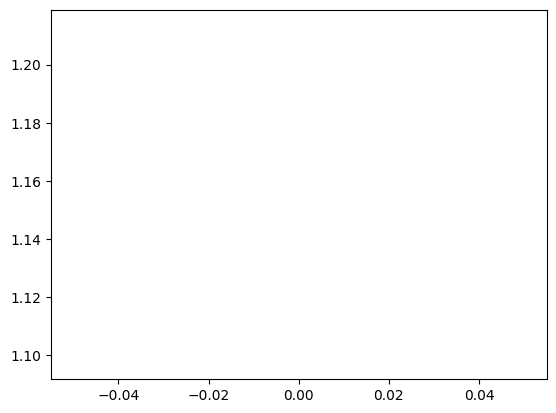

In [8]:
from tqdm import tqdm
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

model = model.to(device) # model on device

# How many runs through the data should we do?
n_epochs = 1

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []


def crop(x):
    # Calculate required crop for the input dims to be divisible by 16
    x_cropped_shape = [(size // 16) * 16 for size in x.shape[-2:]]
    return x[..., :x_cropped_shape[0], :x_cropped_shape[1]]

# The training loop
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(tqdm(train_dataloader)):

        # Get some data and prepare the corrupted version
        x = crop(x.to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)
        
        y = crop(y.to(device) * 2 - 1)
        # Calculate required crop for the input dims to be divisible by 16
        y_cropped_shape = [(size // 16) * 16 for size in y.shape[-2:]]
        y_cropped = y[..., :y_cropped_shape[0], :y_cropped_shape[1]]
        noise = torch.randn_like(y)  # base noise on the target image
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y

        # Predict the noise based on previous images and the noisy forecast target
        pred = model(noisy_y, x, timesteps).reshape(y.shape)

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        print(f"Loss: {loss.item():05f}")
        
        if i % 3 == 0:
            break

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)

In [9]:
losses

[1.1553138494491577]